### Apply PCA and LDA to the project data.

In [35]:
import numpy as np
import sklearn.datasets 
import matplotlib
import matplotlib.pyplot as plt
import scipy.linalg

In [36]:
def vcol(x):
    return x.reshape((x.size, 1))

In [37]:
def vrow(x):
    return x.reshape((1, x.size))

In [38]:
def load(filename):
    DList=[]
    lablesList=[]
    #La classe puo cambiare
    with open(filename) as f:
        for line in f:
            line=line.strip()
            try:
                fields=line.split(',')[0:-1] # prendo tutti i campi tranne l'ultimo ovvero l etichetta
                fields=vcol(np.array([float(x) for x in fields]))
                DList.append(fields)
                label=line.split(',')[-1].strip()
                lablesList.append(label)
            except:
                pass
    return np.hstack(DList),np.array(lablesList,dtype=np.int32)
            

In [39]:
def plot_hist(D,lables,legendFeatures):
    D0=D[:,lables==0]
    D1=D[:,lables==1]
    print(D0.shape)

    for i in range(D.shape[0]):
        plt.figure()
        plt.xlabel(legendFeatures[i])
        plt.ylabel('Density')
        #alpha serve per rendere i colori trasparenti
        plt.hist(D0[i,:],bins=15,alpha=0.4,density=True,label='Fake-FingerPrint')
        plt.hist(D1[i,:],bins=15,alpha=0.4,density=True,label='True-Fingerprint')
        plt.legend()
        plt.tight_layout() # serve per evitare che le etichette siano tagliate
    plt.show()

In [40]:
def plot_scatter(D,lables,legendFeatures):
    D0=D[:,lables==0]
    D1=D[:,lables==1]

    for i in range(D.shape[0]):
        for j in range(i+1,D.shape[0]):
            plt.figure()
            plt.xlabel(legendFeatures[i])
            plt.ylabel(legendFeatures[j])
            plt.scatter(D0[i,:],D0[j,:],alpha=0.4,label='Fake-FingerPrint')
            plt.scatter(D1[i,:],D1[j,:],alpha=0.4,label='True-Fingerprint')
            plt.legend()
            plt.tight_layout() # serve per evitare che le etichette siano tagliate
    plt.show()

Start analyzing the effects of **PCA** on the features. Plot
the histogram of the projected features for the 6 PCA directions, starting from the principal (largest
variance).

In [41]:
#prima di essre processati i dati devono essere spostati nell origini, ovvero avere media 0
def compute_mu_C(X):
    "Calcolo la media e la matrice di covarianza dei dati x"
    mu = vcol(X.mean(1))

    C = ((X-mu)@(X-mu).T)/float(X.shape[1])
    return mu, C

In [42]:
def compute_pca(X,m):
    mu,C=compute_mu_C(X)
    U,s,Vh=scipy.linalg.svd(C) #ritorna autovalori e autovettori dal più grande al più piccolo
    P=U[:,0:m] #prendo le prime m colonne
    return P

(6, 2990)


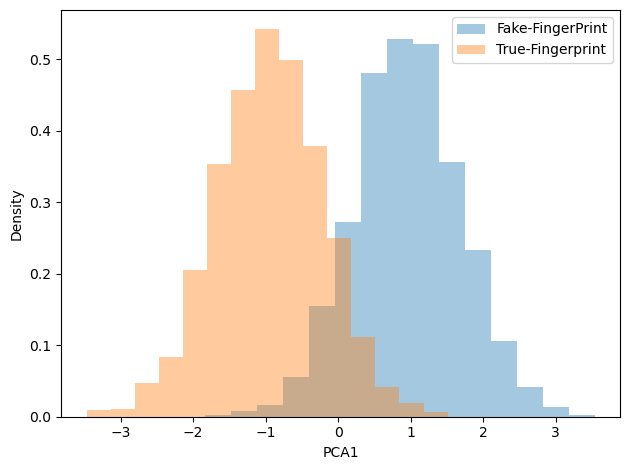

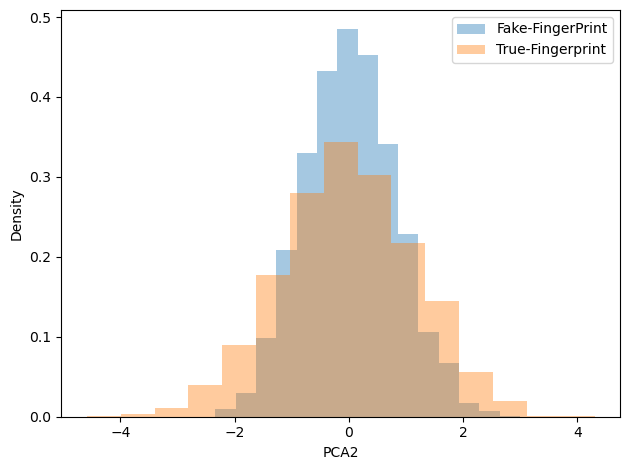

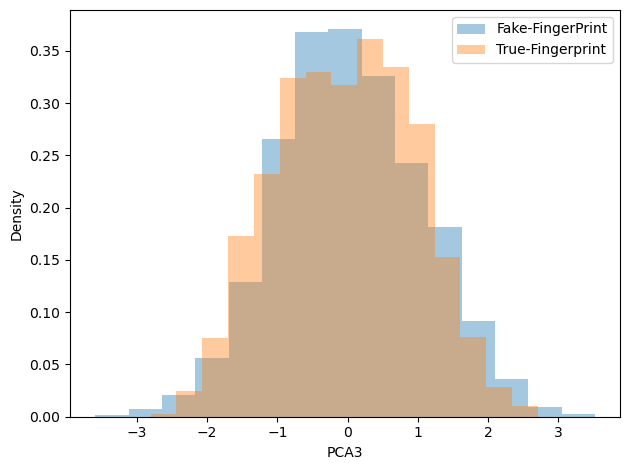

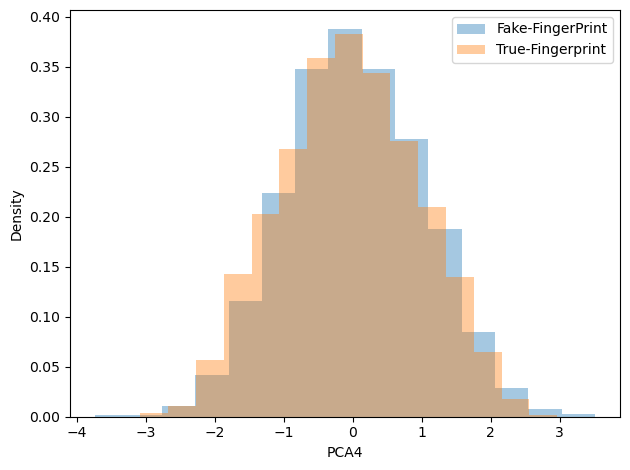

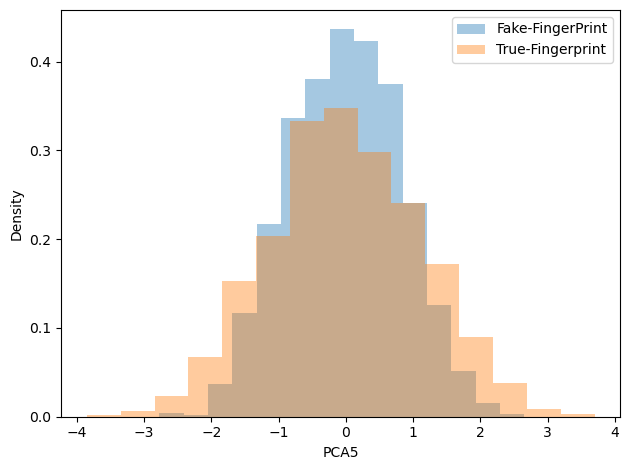

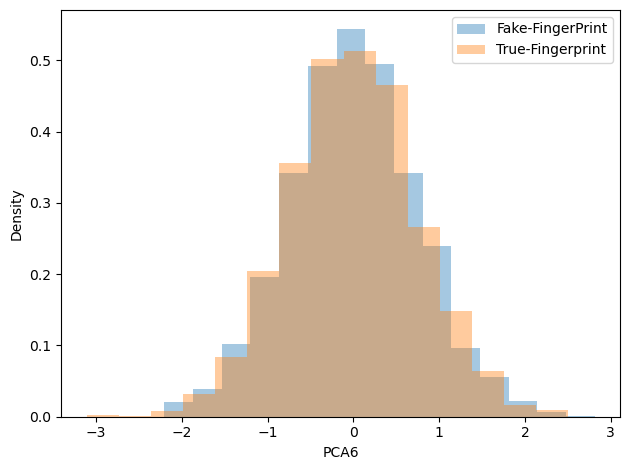

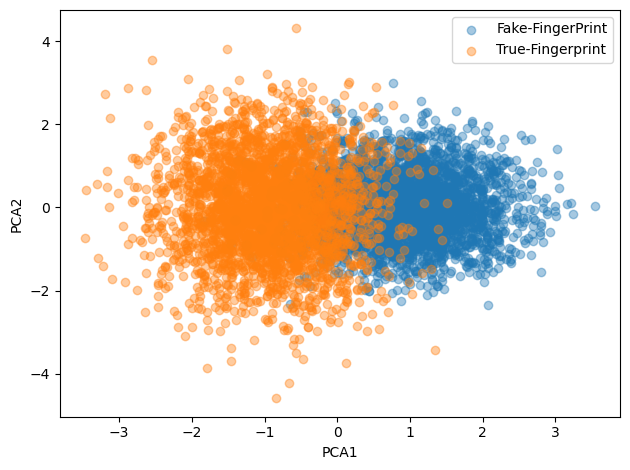

In [43]:
D,lables=load('trainData.txt')
P=compute_pca(D,6) #prendo tutte le direzioni possibili della pca(Ordinate decrescente in base al valorre dell autovalore corrispondente)
Dpca=P.T @ D #proiezione dei dati su P
plot_hist(Dpca,lables,['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6'])  
plot_scatter(Dpca[:2,:],lables,['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6'])

What do you observe? What are the effects on the class distribution? Can you spot the
different clusters inside each class?
The PCA-transformed features show different distribution for individual features and different scatter
plots. However, recall that PCA with 6 dimensions corresponds to just a rotation of the features. Have
the clusters really changed? Have the classes really become “more separated”? (hint: the answer to both
questions is no). This shows us that, while useful, exploratory analysis like histograms and scatter plots
is often not sufficient to understand the global characteristics of our dataset, despite still giving some
useful insights, as we will see in the next laboratories.


#### What Do You Observe?
The PCA-transformed features exhibit different distributions for individual features and scatter plots compared to the original features. Notably, in the scatter plot of the **first principal component (PC1)**, which preserves the maximum variance, it is possible to distinguish the two clusters corresponding to the **Fake Fingerprint** and **True Fingerprint** classes more clearly. However, this separation is only visible in specific projections (e.g., PC1) and not across all dimensions.

#### Effects on Class Distribution
- **Class Separation**: While the projection onto PC1 suggests better separation between the two classes, this is a result of viewing the data along the direction of maximum variance. In the full 6-dimensional PCA space, the classes are not inherently more separated; the apparent separation is an artifact of the projection.
- **Cluster Structure**: The clusters themselves have not changed. PCA is a linear transformation that rotates the feature space but does not alter the underlying geometry of the data. The clusters are simply viewed from different angles, which can create the illusion of better or worse separation depending on the projection.

#### Clusters Within Each Class
- In the scatter plot of PC1, the two clusters (Fake and True Fingerprints) appear more distinct, but this is only a partial view of the data.
- In the full 6-dimensional PCA space, the clusters remain the same as in the original feature space. The global structure and relationships between the data points are preserved, even though individual projections may suggest otherwise.

#### Implications
- **Usefulness of PCA**: PCA is a valuable tool for dimensionality reduction and visualization, as it highlights directions of maximum variance and can reveal patterns in specific projections. However, it does not fundamentally alter the structure or separability of the data.(The separation isn't in scope)
- **Need for Comprehensive Analysis**: To fully understand the dataset, exploratory analysis should be complemented with other techniques that consider the global structure of the data, such as clustering algorithms, manifold learning, or advanced classification methods.



In [44]:
def compute_Sb_Sw(D,L):
    Sb=0
    Sw=0
    muGlobal=vcol(D.mean(1))
    for i in np.unique(L):
        DCls=D[:,L==i]
        muCls=vcol(DCls.mean(1))
        Sb+=DCls.shape[1]*(muCls-muGlobal)@(muCls-muGlobal).T
        Sw+=(DCls-muCls)@(DCls-muCls).T
    return Sb/D.shape[1],Sw/D.shape[1]  

In [45]:
def compute_lda(D,L,m=2,ortogonalize=False):
    if m > D.shape[0]:
        raise ValueError('m must be less than the number of classes')
    Sb,Sw=compute_Sb_Sw(D,L)
    s, U = scipy.linalg.eigh(Sb, Sw)
    W = U[:, ::-1][:, 0:m]
    if ortogonalize:
        UW, _, _ = np.linalg.svd(W)
        W = UW[:, 0:m]
    return W

Apply **LDA** (1 dimensional, since we have just two classes), and compute the histogram of the projected
LDA samples. 

(1, 2990)


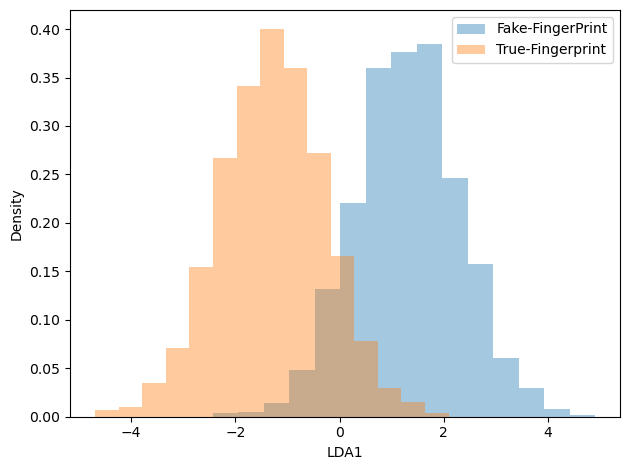

In [46]:
D,lables=load('trainData.txt')
#m=1 perchè le classi sono 2, le altre direzioni non sono significative
U=compute_lda(D,lables,1)
Dlda=U.T @ D
plot_hist(Dlda,lables,['LDA1','LDA2'])

What do you observe? Do the classes overlap over the found direction? Compared to the
histograms of the 6 features you computed in Laboratory 2, is LDA finding a good direction with little
class overlap? (Note: LDA is not increasing the separation between classes, it’s finding a direction in
the original feature space along which the classes are already well separated).


#### What Do You Observe?
After applying **Linear Discriminant Analysis (LDA)** to the dataset, the following observations can be made:

1. **Class Separation**:
   - The LDA-projected samples show a clear separation between the **Fake Fingerprint** and **True Fingerprint** classes along the found direction.
   - The classes are well-separated, with only a **small overlap around the zero region**.

2. **Histogram of LDA-Projected Samples**:
   - The histogram of the projected samples reveals two distinct peaks corresponding to the two classes.
   - The **Fake Fingerprint** class is concentrated on one side of the projection, while the **True Fingerprint** class is concentrated on the other side.
   - The overlap between the classes is minimal and occurs primarily around the **zero region**.

3. **Comparison with Histograms of Original Features**:
   - Compared to the histograms of the **6 original features** computed in Laboratory 2, the LDA-projected direction provides significantly better separation between the classes.
   - In the original features, the classes often overlapped significantly, especially around the central regions (e.g., near zero for Features 0 and 1).
   - LDA has identified a direction in the original feature space where the classes are **already well-separated**, minimizing overlap and maximizing class discrimination.

#### Implications
- **Usefulness of LDA**:
  - LDA is particularly effective for datasets with two classes, as it finds a 1-dimensional projection that maximizes class separability.
  - This projection can be used as a feature for training classifiers, potentially improving their performance.
- **Limitations**:
  - While LDA provides excellent separation in this case, it assumes linear separability between classes. For more complex datasets with non-linear relationships, other techniques (e.g., kernel LDA or non-linear dimensionality reduction) may be required.


#### First Classifier

Try applying LDA for classification. Divide the dataset in model training and validation sets (you can
reuse the previous function to split the dataset). Apply LDA, select the orientation that results in the
projected mean of class True (label 1) being larger than the projected mean of class False (label 0),
and select the threshold as in the previous sections, i.e., as the average of the projected class means.
Compute the predictions on the validation data, and the corresponding error rate.

In [47]:
def split_db_2to1(D, L, seed=0):
    nTrain = int(D.shape[1]*2.0/3.0)
    np.random.seed(seed)
    idx = np.random.permutation(D.shape[1])
    idxTrain = idx[0:nTrain]
    idxTest = idx[nTrain:]
    DTR = D[:, idxTrain]
    DVAL = D[:, idxTest]
    LTR = L[idxTrain]
    LVAL = L[idxTest]
    return (DTR, LTR), (DVAL, LVAL)

In [48]:
def classify_evaluetion(DTR,LTR,DVAL,LVAL):
    "DTR e DVAL sono i dati di training e di validation, LTR e LVAL sono le etichette associate"
    "I dati devono essere gia proiettati sulle nuove dimensioni"
    "Restituisce le etichette predette"
    
    threshold = ((DTR[0, LTR == 0].mean() + DTR[0, LTR == 1].mean()) / 2)
    print("Mean of class True:", DTR[0, LTR == 1].mean())
    print("Mean of class False:", DTR[0, LTR == 0].mean())
    print("Threshold:", threshold)
    PVAL = np.zeros(shape=LVAL.shape, dtype=np.int32)
    PVAL[DVAL[0] > threshold] = 1
    PVAL[DVAL[0] <= threshold] = 0
    print("Labels:", LVAL)
    print("Predicted:", PVAL)
    print("Number of errors:", np.sum(LVAL != PVAL), "out of", LVAL.size,"samples")
    print("Accuracy:",1-np.sum(LVAL!=PVAL)/LVAL.size)
    print("Error rate (%):",np.sum(LVAL!=PVAL)/LVAL.size*100)
    return PVAL

In [49]:
D,lables=load('trainData.txt')
(DTR, LTR), (DVAL, LVAL) = split_db_2to1(D, lables)
U=compute_lda(DTR,LTR,1)
DTRlda=U.T @ DTR
DVALlda=U.T@ DVAL
if DTRlda[0, LTR == 0].mean() > DTRlda[0, LTR == 1].mean():
    DTRlda = -DTRlda
    DVALlda = -DVALlda
classify_evaluetion(DTRlda,LTR,DVALlda,LVAL)

Mean of class True: 1.2605215263660918
Mean of class False: -1.2975902799385062
Threshold: -0.018534376786207174
Labels: [0 0 1 ... 0 0 0]
Predicted: [0 0 1 ... 0 0 0]
Number of errors: 186 out of 2000 samples
Accuracy: 0.907
Error rate (%): 9.3


array([0, 0, 1, ..., 0, 0, 0])

Now try changing the value of the threshold. What do you observe? Can you find values that improve
the classification accuracy?

In [50]:
PVAL=np.zeros(shape=LVAL.shape,dtype=np.int32)
threshold =[0,0.01,1,-0.02,-0.05]
for i in threshold:
    PVAL[DVALlda[0]>i]=1
    PVAL[DVALlda[0]<=i]=0
    print()
    print("Threshold:",i)
    print("Number of errors:",np.sum(LVAL!=PVAL),"out of",LVAL.size,"samples")
    print("Accuracy:",1-np.sum(LVAL!=PVAL)/LVAL.size)
    print("Error rate (%):",np.sum(LVAL!=PVAL)/LVAL.size*100)


Threshold: 0
Number of errors: 186 out of 2000 samples
Accuracy: 0.907
Error rate (%): 9.3

Threshold: 0.01
Number of errors: 185 out of 2000 samples
Accuracy: 0.9075
Error rate (%): 9.25

Threshold: 1
Number of errors: 385 out of 2000 samples
Accuracy: 0.8075
Error rate (%): 19.25

Threshold: -0.02
Number of errors: 185 out of 2000 samples
Accuracy: 0.9075
Error rate (%): 9.25

Threshold: -0.05
Number of errors: 186 out of 2000 samples
Accuracy: 0.907
Error rate (%): 9.3


Testing different threshold values reveals that setting the threshold to **0.01** improves the accuracy by **0.0005**. However, since this value is already within the optimal range around **0**, further deviations from the mean lead to a degradation in performance. This suggests that the initial threshold is already near optimal, and only minimal adjustments within this range provide negligible improvements.

Finally, try pre-processing the features with PCA. Apply PCA (estimated on the model training data
only), and then classify the validation data with LDA. Analyze the performance as a function of the
number of PCA dimensions m. 

In [51]:
D,lables=load('trainData.txt')  
(DTR, LTR), (DVAL, LVAL) = split_db_2to1(D, lables)
m_try=[2,3,4,5,6]
for m in m_try:
    P=compute_pca(DTR,m)
    DTRpca=P.T @ DTR
    DVALpca=P.T @ DVAL
    U=compute_lda(DTRpca,LTR,1)
    DTRlda=U.T @ DTRpca
    DVALlda=U.T @ DVALpca
    print("PCA:",m)
    if DTRlda[0, LTR == 0].mean() > DTRlda[0, LTR == 1].mean():
        DTRlda = -DTRlda
        DVALlda = -DVALlda    
    classify_evaluetion(DTRlda,LTR,DVALlda,LVAL)
    print()
    

PCA: 2


Mean of class True: 1.2571506513751096
Mean of class False: -1.293714158028681
Threshold: -0.01828175332678572
Labels: [0 0 1 ... 0 0 0]
Predicted: [0 0 1 ... 0 0 0]
Number of errors: 185 out of 2000 samples
Accuracy: 0.9075
Error rate (%): 9.25

PCA: 3
Mean of class True: 1.2599122032685404
Mean of class False: -1.2967085830467484
Threshold: -0.018398189889104022
Labels: [0 0 1 ... 0 0 0]
Predicted: [0 0 1 ... 0 0 0]
Number of errors: 185 out of 2000 samples
Accuracy: 0.9075
Error rate (%): 9.25

PCA: 4
Mean of class True: 1.260313510116576
Mean of class False: -1.2969477750132739
Threshold: -0.018317132448348872
Labels: [0 0 1 ... 0 0 0]
Predicted: [0 0 1 ... 0 0 0]
Number of errors: 185 out of 2000 samples
Accuracy: 0.9075
Error rate (%): 9.25

PCA: 5
Mean of class True: 1.2604640563574852
Mean of class False: -1.2975024126730599
Threshold: -0.018519178157787364
Labels: [0 0 1 ... 0 0 0]
Predicted: [0 0 1 ... 0 0 0]
Number of errors: 186 out of 2000 samples
Accuracy: 0.907
Error rat

What do you observe? Can you find values of m that improve the
accuracy on the validation set? Is PCA beneficial for the task when combined with the LDA classifier?

Applying PCA preprocessing before LDA classification does not significantly improve the accuracy on the validation set. The performance remains stable across different numbers of PCA dimensions (m = 2 to 6), with only a minimal improvement observed for m = 2. This suggests that PCA is not particularly beneficial for this task when combined with the LDA classifier, as the original features already provide a good representation for classification. Therefore, in this scenario, using PCA preprocessing does not add substantial value to the LDA-based classification pipeline.